In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Divvy data

## Load and concat the Divvy datasets
Download Divvy 2017 datasets from here: https://www.divvybikes.com/system-data

In [ ]:
divvy1 = pd.read_csv('data/Divvy_Trips_2017_Q1Q2/Divvy_Trips_2017_Q1.csv', parse_dates=['start_time', 'end_time'])
divvy2 = pd.read_csv('data/Divvy_Trips_2017_Q1Q2/Divvy_Trips_2017_Q2.csv', parse_dates=['start_time', 'end_time'])
divvy3 = pd.read_csv('data/Divvy_Trips_2017_Q3Q4/Divvy_Trips_2017_Q3.csv', parse_dates=['start_time', 'end_time'])
divvy4 = pd.read_csv('data/Divvy_Trips_2017_Q3Q4/Divvy_Trips_2017_Q4.csv', parse_dates=['start_time', 'end_time'])

divvy = pd.concat([divvy1, divvy2, divvy3, divvy4], ignore_index=True)

divvy.to_csv('data/divvy_2017.csv', index=False)

In [ ]:
divvy = pd.read_csv('data/divvy_2017.csv')

In [ ]:
station_list = set(list(divvy['from_station_name'].unique()) + list(divvy['to_station_name'].unique()))

In [ ]:
len(station_list)

## Load Divvy station info for GPS coordinates
Download the stations json file from the same location: https://www.divvybikes.com/system-data

In [ ]:
with open('data/stations.json') as json_data:
    station_data = json.load(json_data)

In [ ]:
station_data['stationBeanList']

In [ ]:
stations = [station['stationName'] for station in station_data['stationBeanList']]
latitude = [station['latitude'] for station in station_data['stationBeanList']]
longitude = [station['longitude'] for station in station_data['stationBeanList']]

In [ ]:
# unknown = []
# for station in station_list:
#     if station not in stations:
#         unknown.append(station)
# unknown

In [ ]:
station_gps = pd.DataFrame({'station_name': stations, 'latitude': latitude, 'longitude': longitude})

In [ ]:
station_gps.head()

In [ ]:
def gps_lookup(location):
    match = (station_gps['station_name'] == location)
    coord = station_gps['latitude'][match]
    if len(coord) > 0:
        return pd.Series([coord.values[0], station_gps['longitude'][match].values[0]])
    else:
        return pd.Series([np.nan, np.nan])

In [ ]:
divvy[['from_station_latitude', 'from_station_longitude']] = divvy['from_station_name'].apply(gps_lookup)
divvy[['to_station_latitude', 'to_station_longitude']] = divvy['to_station_name'].apply(gps_lookup)

In [ ]:
divvy.to_csv('data/divvy_2017.csv', index=False)

In [26]:
divvy = pd.read_csv('data/divvy_2017.csv')

### 1) Top 5 stations with the most starts (showing # of starts)

In [ ]:
station_starts = divvy.groupby(['from_station_name'])['from_station_name'].count().sort_values(ascending=False)
station_starts.head()

In [ ]:
ax = station_starts.head(5).plot(kind='bar', figsize=(15, 10), title='Top 5 Stations with Most Starts')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + .15, p.get_height() * 1.005))

### 2) Trip duration by user type

In [ ]:
trip_duration = divvy.groupby(['usertype'])['tripduration'].mean().sort_values(ascending=False)
trip_duration

In [ ]:
ax = divvy.boxplot(column='tripduration', by='usertype', figsize=(15,10))

In [ ]:
ax = divvy.boxplot(column='tripduration', by='usertype', figsize=(15,10), showfliers=False)

### 3) Most popular trips based on start station and stop station

In [ ]:
divvy['trip_stations'] = divvy['from_station_name'] + ' TO ' + divvy['to_station_name']

In [ ]:
trip_stations = divvy.groupby(['trip_stations'])['trip_stations'].count().sort_values(ascending=False)
trip_stations.head()

In [ ]:
ax = trip_stations.head(10).plot(kind='bar', figsize=(15, 10), title='Top 10 Most Popular Trips')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + .05, p.get_height() * 1.005))

### Create dataframe of paths for Tableau chart

In [ ]:
trip_dict = {'path': list(trip_stations.index), 'frequency': list(trip_stations.values)}
trip_dict['origin'] = [x.split(' TO ')[0] for x in trip_dict['path']]
trip_dict['destination'] = [x.split(' TO ')[1] for x in trip_dict['path']]

In [ ]:
from collections import defaultdict

trips = defaultdict(list)

for idx in range(len(trip_dict['path'])):
    trips['path'].append(trip_dict['path'][idx])
    trips['frequency'].append(trip_dict['frequency'][idx])
    trips['origin-destination'].append('origin')
    trips['station'].append(trip_dict['origin'][idx])
    
    trips['path'].append(trip_dict['path'][idx])
    trips['frequency'].append(trip_dict['frequency'][idx])
    trips['origin-destination'].append('destination')
    trips['station'].append(trip_dict['destination'][idx])

In [ ]:
stations_gps = (divvy[divvy['from_station_name'].duplicated()]
                [['from_station_name', 'from_station_latitude', 'from_station_longitude']].reset_index(drop=True))

In [ ]:
trips_df = pd.DataFrame(trips).merge(stations_gps.drop_duplicates(subset=['from_station_name']),
                                     how='left',
                                     left_on='station',
                                     right_on='from_station_name')

In [ ]:
trips_df.drop(['from_station_name'], axis=1, inplace=True)

In [ ]:
trips_df.to_csv('data/divvy_trips.csv')

### 4) Rider performance by Gender and Age based on avg trip distance (station to station), median speed (distance traveled / trip duration)

Multiply geodesic distance by 1.25. Routes follow roads but the calculated route is direct (geodesic). A route straight down a road would be the same as the direct route; a route diagnoal to roads would be multiplied by 1.414 (thanks, Pythagoras!); assuming routes are evenly split between diagonal and direct, with some wiggle room, I'm splitting the difference at 1.25.

I looked at using the Google Maps api to calculate the actual, along-the-road distance, but they've removed the free api key option. I also looked at Bing Maps, but it's rate limited and I have more than 98,000 routes in this dataset (and once I saw how big that number was, I realized that using api calls would take more than a few days!). So I opted for this *x1.25* method which is less accurate but far quicker and cheaper.

In [ ]:
from math import isnan

def find_distance(row):
    if (not isnan(row['from_station_latitude']) and
        not isnan(row['from_station_longitude']) and
        not isnan(row['to_station_latitude']) and
        not isnan(row['to_station_longitude'])):
        return (1.25 * (geopy.distance.distance((row['from_station_latitude'], row['from_station_longitude']),
                                                (row['to_station_latitude'], row['to_station_longitude'])).m))
    return np.nan

In [ ]:
from math import isnan

def find_distance(row):
    if (not isnan(row['from_station_latitude']) and
        not isnan(row['from_station_longitude']) and
        not isnan(row['to_station_latitude']) and
        not isnan(row['to_station_longitude'])):
        distance = (1.25 * (geopy.distance.distance((row['from_station_latitude'], row['from_station_longitude']),
                                                (row['to_station_latitude'], row['to_station_longitude'])).m))
        print(distance)
        return distance
    else:
        print(np.nan)
    return np.nan

In [ ]:
divvy['trip_distance'] = divvy.apply(find_distance, axis=1)
divvy['speed'] = divvy['trip_distance'] / divvy['tripduration']

In [ ]:
divvy.to_csv('data/divvy_2017.csv')

In [ ]:
divvy = pd.read_csv('data/divvy_2017.csv')

# Yelp data
Download Yelp datasets from here: https://www.yelp.com/dataset/

In [ ]:
business = pd.read_json('data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)

checkin = pd.read_json('data/yelp_dataset/yelp_academic_dataset_checkin.json', lines=True)

max_records = 1e5
df = pd.read_json('data/yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=max_records)
review = pd.DataFrame() # Initialize the dataframe
try:
    for df_chunk in df:
        review = pd.concat([review, df_chunk])
except ValueError:
    print ('\nSome messages in the file cannot be parsed')

In [ ]:
business.head()

In [ ]:
checkin.head()

In [ ]:
review.head()

In [ ]:
checkin['checkins'] = checkin['time'].apply(lambda x : sum(x.values()))
yelp = business.merge(checkin, on='business_id', how='outer')

In [ ]:
review['date'] = pd.to_datetime(review['date'])
review = review[review['date'].dt.year == 2017]

In [ ]:
business.to_csv('data/yelp_business.csv', index=False)
checkin.to_csv('data/yelp_checkin.csv', index=False)
review.to_csv('data/yelp_review.csv', index=False)
yelp.to_csv('data/yelp.csv', index=False)

In [2]:
business = pd.read_csv('data/yelp_business.csv')
checkin = pd.read_csv('data/yelp_checkin.csv')
review = pd.read_csv('data/yelp_review.csv')
yelp = pd.read_csv('data/yelp.csv')

### Find the top 10 and bottom 10 restaurants in Illinois having most and least checkins respectively.

In [ ]:
yelp.head()

In [ ]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'].isnull()) &
         (yelp['is_open'] == 1)])

In [ ]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 1) &
         (yelp['is_open'] == 1)])

In [ ]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 2) &
         (yelp['is_open'] == 1)])

In [ ]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 3) &
         (yelp['is_open'] == 1)])

In [ ]:
top10 = yelp[(yelp['state'] == 'IL') &
             (yelp['categories'].str.contains('Restaurants') &
              (yelp['is_open'] == 1))
            ].sort_values('checkins', ascending=False).head(10)

bottom10 = yelp[(yelp['state'] == 'IL') &
                (yelp['categories'].str.contains('Restaurants') &
                (yelp['is_open'] == 1))
               ].sort_values('checkins', ascending=False).tail(30)

In [ ]:
top10.to_csv('data/yelp_top10_checkins.csv', index=False)
bottom10.to_csv('data/yelp_bottom10_checkins.csv', index=False)

In [ ]:
top10_names = top10['name'].tolist()
top10_names

In [ ]:
bottom10_names = bottom10['name'].tolist()
bottom10_names

### For the top 10 and bottom 10 restaurants calculated in step 6, calculate the average star rating and average sentiment score of the reviews

In [ ]:
top_bottom = top10['business_id'].tolist() + bottom10['business_id'].tolist()

In [ ]:
np.random.choice(doc_clean, 50000, replace=False).tolist()
top_bottom = (np.random.choice(top10['business_id'].tolist(), 1000, replace=False).tolist() +
              np.random.choice(bottom10['business_id'].tolist(), 1000, replace=False).tolist())


In [ ]:
sentiment = review[review['business_id'].isin(top_bottom)]

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_vader_scores(text):
    '''
    Takes a string of text and outputs four values for Vader's negative,
    neutral, positive, and compound (normalized) sentiment scores
    INPUT: a string
    OUTPUT: a dictionary of four sentiment scores
    '''

    analyser = SentimentIntensityAnalyzer()
    return analyser.polarity_scores(text)


def apply_vader(df, column):
    '''
    Takes a DataFrame with a specified column of text and adds four new columns
    to the DataFrame, corresponding to the Vader sentiment scores
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with four additional columns
    '''

    sentiment = pd.DataFrame(df[column].apply(get_vader_scores))
    unpacked = pd.DataFrame([d for idx, d in sentiment['text'].iteritems()],
                            index=sentiment.index)
    unpacked['compound'] += 1
    columns = {'neu': 'v_neutral', 'pos': 'v_positive', 'neg': 'v_negative'}
    unpacked.rename(columns=columns, inplace=True)
    return pd.concat([df, unpacked], axis=1)

In [ ]:
sentiment = apply_vader(sentiment, 'text')

In [ ]:
top10_sentiment = {}
for biz_id in top10['business_id'].tolist():
    top10_sentiment[yelp.loc[yelp['business_id'] == biz_id, 'name'].iloc[0]] = sentiment[sentiment['business_id'] == biz_id].groupby(['business_id']).mean()

In [ ]:
top10_scores = pd.DataFrame()
for restaurant in top10_sentiment:
    top10_scores = top10_scores.append(pd.DataFrame(top10_sentiment[restaurant]))
top10_scores.reset_index(level=0, inplace=True)

In [ ]:
top10_scores['name'] = top10_scores['business_id'].apply(lambda business_id: yelp['name']
                                                         [(yelp['business_id'] == business_id)].values[0])

In [ ]:
top10_scores

In [ ]:
bottom10_sentiment = {}
for biz_id in bottom10['business_id'].tolist():
    bottom10_sentiment[yelp.loc[yelp['business_id'] == biz_id, 'name'].iloc[0]] = sentiment[sentiment['business_id'] == biz_id].groupby(['business_id']).mean()

In [ ]:
bottom10_scores = pd.DataFrame()
for restaurant in bottom10_sentiment:
    bottom10_scores = bottom10_scores.append(pd.DataFrame(bottom10_sentiment[restaurant]))
bottom10_scores.reset_index(level=0, inplace=True)

In [ ]:
bottom10_scores['name'] = bottom10_scores['business_id'].apply(lambda business_id: yelp['name']
                                                               [(yelp['business_id'] == business_id)].values[0])

In [ ]:
bottom10_scores

In [ ]:
top10_scores.to_csv('data/yelp_top_scores.csv', index=False)
bottom10_scores.to_csv('data/yelp_bottom_scores.csv', index=False)

### What are the top 10 Cuisine types (Mexican, American, Thai, etc) based on the number of restaurants and number of check ins

In [ ]:
restaurants = yelp[yelp['categories'].str.contains('Restaurants', na=False)]

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
restaurants['categories'] = restaurants['categories'].apply(lambda x: x.split(', '))

In [ ]:
restaurants = restaurants.join(pd.get_dummies(pd.DataFrame(restaurants['categories'].tolist()).stack()).astype(int).sum(level=0))

In [ ]:
columns = [item for item in restaurants.columns.tolist() if item not in yelp.columns.tolist()]
columns.remove('Restaurants')

In [ ]:
num_restaurants = restaurants[columns].sum(numeric_only=True).sort_values(ascending=False)
num_restaurants

In [ ]:
checkin_dict ={}
for item in columns:
    cnt = restaurants[restaurants[item] == 1].groupby([item])['checkins'].sum()
    if cnt.empty:
        checkin_dict[item] = 0
    else:
        checkin_dict[item] = restaurants[restaurants[item] == 1].groupby([item])['checkins'].sum().values[0]

In [ ]:
checkin_dict = pd.Series(checkin_dict).sort_values(ascending=False)

In [ ]:
checkin_dict

In [ ]:
for item in checkin_dict.keys():
    print(item)

In [ ]:
pd.DataFrame(checkin_dict).to_csv('data/yelp_cuisine_checkin.csv')
pd.DataFrame(num_restaurants).to_csv('data/yelp_cuisine_restaurants.csv')

### What are the most popular keywords or adjectives that reviewers use for the above list of cuisines (calculated in step 8)

In [ ]:
cuisine_list = ['American (Traditional)', 'Mexican', 'Chinese', 'Italian', 'American (New)',
               'Japanese', 'Thai', 'Mediterranean', 'Asian Fusion', 'Indian', 'Korean',
                'Greek', 'Middle Eastern', 'Vietnamese', 'French', 'Tex-Mex', 'Caribbean']
cuisines = pd.DataFrame()
for cuisine in cuisine_list:
    businesses = yelp[yelp['categories'].str.contains(cuisine, na=False)]['business_id'].tolist()
    temp = review[review['business_id'].isin(businesses)]
    temp['cuisine'] = cuisine
    cuisines = pd.concat([cuisines, temp], ignore_index=True)

In [ ]:
cuisines.head()

In [ ]:
import spacy
from collections import Counter

nlp = spacy.load('en')

nlp.max_length = 1500000

In [ ]:
cuisine_docs = {}

for cuisine in cuisine_list:
    print()
    print(cuisine)
    text = cuisines[cuisines['cuisine'] == cuisine]['text'].str.cat(sep=' ')
    chunk_size = 1000000
    num_chunks = len(text) // chunk_size + 1
    
    words = []
    adj = []
    
    for chunk in range(num_chunks):
        print('  chunk', chunk + 1, 'of', num_chunks)
        chunk_start = chunk_size * (chunk - 1)
        chunk_end = chunk_size * chunk
        chunk_text = text[chunk_start: chunk_end]
    
        doc = nlp(chunk_text)
        # all tokens that arent stop words or punctuations
        words.extend([token.text for token in doc if
                      token.is_stop !=True and token.is_punct != True])

        # adjective tokens that arent stop words or punctuations
        adj.extend([token.text for token in doc if
                    token.is_stop != True and
                    token.is_punct != True and token.pos_ == "ADJ"])

    # 200 most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(200)

    # five most common adjective tokens
    adj_freq = Counter(adj)
    common_adj = adj_freq.most_common(200)
    
    cuisine_docs[cuisine] = {'words': words,
                               'adj': adj,
                               'common_words': common_words,
                               'common_adj': common_adj}

In [ ]:
for cuisine in cuisine_docs.keys():
    with open('data/yelp_cuisine_' + cuisine + '.json', 'w') as fp:
        json.dump(cuisine_docs[cuisine], fp)

In [ ]:
cuisine_df = pd.DataFrame()

for cuisine in cuisine_docs.keys():
    temp = pd.DataFrame({'words': ' '.join(cuisine_docs[cuisine]['words']).replace('\n', ' ').replace('\r', ''),
                         'adj': ' '.join(cuisine_docs[cuisine]['adj']).replace('\n', ' ').replace('\r', ''),
                         'common_words': [cuisine_docs[cuisine]['common_words']],
                         'common_adj': [cuisine_docs[cuisine]['common_adj']]})
    temp['cuisine'] = cuisine
    cuisine_df = pd.concat([cuisine_df, temp], ignore_index=True)

In [ ]:
cuisine_df.head(50)

In [ ]:
cuisine_df.to_csv('data/yelp_cuisine_words.csv', index=False)

## The Mayor would like Divvy Bike to add a new feature to their kiosks: “Enter a destination and we’ll tell you how long the trip will take”. We need you to build a model that can predict how long a trip will take given a starting point and destination. You will need to get creative about the factors that will predict travel time. For example, weather and traffic patterns may have an impact on Divvy Bike travel time. There is certainly dataout there –you just should find it.

### Download weather data from Weather Underground
Unfortunately, Weather Underground has started charging for their API: https://www.wunderground.com/weather/api

In [ ]:
# Query data in different years
# You can get keys from https://www.wunderground.com/
keys = ['***************', '***************', '***************', 
        '***************', '***************']
years = [2017]

for key, year in zip(keys, years):
    path = './data/weather_' + str(year) + '.csv'
    if os.path.isfile(path):
        continue
    df, _ = query_weather(key=key, year=year, state='IL', area='Chicago')
    df.to_csv(path, index=False)
    print('File saved:\t', path)

### so, just join with the Kaggle dataset instead
download the dataset here: https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data

We'll be only extracting the weather information from this dataset

In [20]:
divvy_kaggle = pd.read_csv('data/chicago-divvy-bicycle-sharing-data/data_raw.csv', parse_dates=['starttime', 'stoptime'])

In [21]:
divvy_kaggle = divvy_kaggle[divvy_kaggle['starttime'].dt.year == 2017].reset_index(drop=True)

In [22]:
# divvy_kaggle.to_csv('data/divvy_2017_kaggle.csv')

In [23]:
divvy_kaggle = pd.read_csv('data/divvy_2017_kaggle.csv')

In [24]:
divvy_kaggle.columns

Index(['Unnamed: 0', 'trip_id', 'usertype', 'gender', 'starttime', 'stoptime',
       'tripduration', 'from_station_id', 'from_station_name',
       'latitude_start', 'longitude_start', 'dpcapacity_start',
       'to_station_id', 'to_station_name', 'latitude_end', 'longitude_end',
       'dpcapacity_end', 'temperature', 'windchill', 'dewpoint', 'humidity',
       'pressure', 'visibility', 'wind_speed', 'precipitation', 'events',
       'rain', 'conditions'],
      dtype='object')

In [27]:
divvy.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear',
       'from_station_latitude', 'from_station_longitude',
       'to_station_latitude', 'to_station_longitude', 'trip_distance',
       'speed'],
      dtype='object')

In [28]:
len(divvy_kaggle)

3826746

In [29]:
len(divvy)

3829014

In [30]:
df = divvy.merge(divvy_kaggle[['trip_id', 'temperature', 'windchill',
                               'dewpoint', 'humidity', 'pressure',
                               'visibility', 'wind_speed',
                               'precipitation', 'events',
                               'rain', 'conditions']], on='trip_id', how='inner')

In [31]:
df.dropna(inplace=True)
df = df[(df['tripduration'] <= 3600) & (df['trip_distance'] >= 200)]

In [32]:
df.to_csv('data/divvy_weather.csv', index=False)

In [33]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear',
       'from_station_latitude', 'from_station_longitude',
       'to_station_latitude', 'to_station_longitude', 'trip_distance', 'speed',
       'temperature', 'windchill', 'dewpoint', 'humidity', 'pressure',
       'visibility', 'wind_speed', 'precipitation', 'events', 'rain',
       'conditions'],
      dtype='object')

In [34]:
df.head()

,Unnamed: 0,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,...,windchill,dewpoint,humidity,pressure,visibility,wind_speed,precipitation,events,rain,conditions
0,0,13518905,2017-03-31 23:59:07,2017-04-01 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
1,1,13518904,2017-03-31 23:56:25,2017-04-01 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
2,2,13518903,2017-03-31 23:55:33,2017-04-01 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
3,3,13518902,2017-03-31 23:54:46,2017-03-31 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
5,5,13518900,2017-03-31 23:51:17,2017-03-31 23:55:19,3536,242,143,Sedgwick St & Webster Ave,289,Wells St & Concord Ln,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy


In [35]:
df['start_time'] = pd.to_datetime(df['start_time'])

In [36]:
df['day'] = df['start_time'].dt.dayofweek
df['month'] = df['start_time'].dt.month

In [37]:
df = pd.get_dummies(df, columns=['day'])
df = pd.get_dummies(df, columns=['month'])
df = pd.get_dummies(df, columns=['usertype'])
df = pd.get_dummies(df, columns=['events'])
df = pd.get_dummies(df, columns=['conditions'])

### Get traffic data for Chicago rush hours: https://www.illinoisvehicle.com/about-us/blog/traffic-patterns-chicago/

In [38]:
df['morning_rush_hour'] = np.where(((df['start_time'].dt.hour > 6) &
                                    (df['start_time'].dt.hour < 10)),
                                    1, 0)

df['evening_rush_hour'] = np.where(((df['start_time'].dt.hour > 15) &
                                    (df['start_time'].dt.hour < 19)),
                                    1, 0)

df['night'] = np.where(((df['start_time'].dt.hour <= 19) &
                        (df['start_time'].dt.hour <= 6)),
                         1, 0)

df['midday'] = np.where(((df['start_time'].dt.hour >= 10) &
                         (df['start_time'].dt.hour <= 15)),
                         1, 0)

In [39]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'gender', 'birthyear', 'from_station_latitude',
       'from_station_longitude', 'to_station_latitude', 'to_station_longitude',
       'trip_distance', 'speed', 'temperature', 'windchill', 'dewpoint',
       'humidity', 'pressure', 'visibility', 'wind_speed', 'precipitation',
       'rain', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'usertype_Customer', 'usertype_Dependent', 'usertype_Subscriber',
       'events_clear', 'events_cloudy', 'events_fog', 'events_hazy',
       'events_mostlycloudy', 'events_partlycloudy', 'events_rain',
       'events_sleet', 'events_snow', 'events_tstorms', 'conditions_Clear',
       'conditions_Drizzle', 'condit

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
columns = ['trip_distance', 'temperature', 'windchill', 'dewpoint',
           'humidity', 'pressure', 'visibility', 'wind_speed', 'precipitation',
           'rain', 'morning_rush_hour',
           'evening_rush_hour', 'night', 'midday', 'day_0', 'day_1', 'day_2',
           'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3',
           'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
           'month_10', 'month_11', 'month_12', 'usertype_Customer',
           'usertype_Dependent', 'usertype_Subscriber',
           'events_clear', 'events_cloudy', 'events_fog', 'events_hazy',
           'events_mostlycloudy', 'events_partlycloudy', 'events_rain',
           'events_sleet', 'events_snow', 'events_tstorms', 'conditions_Clear',
           'conditions_Drizzle', 'conditions_Fog', 'conditions_Freezing Rain',
           'conditions_Haze', 'conditions_Heavy Rain',
           'conditions_Heavy Thunderstorms and Rain', 'conditions_Light Drizzle',
           'conditions_Light Freezing Drizzle', 'conditions_Light Freezing Rain',
           'conditions_Light Hail', 'conditions_Light Rain',
           'conditions_Light Snow', 'conditions_Light Thunderstorms and Rain',
           'conditions_Mist', 'conditions_Mostly Cloudy', 'conditions_Overcast',
           'conditions_Partly Cloudy', 'conditions_Rain',
           'conditions_Scattered Clouds', 'conditions_Smoke', 'conditions_Snow',
           'conditions_Thunderstorm', 'conditions_Thunderstorms and Rain']

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[columns],
                                                    df['tripduration'],
                                                    test_size=0.2, random_state=0)

In [43]:
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6953254654844158

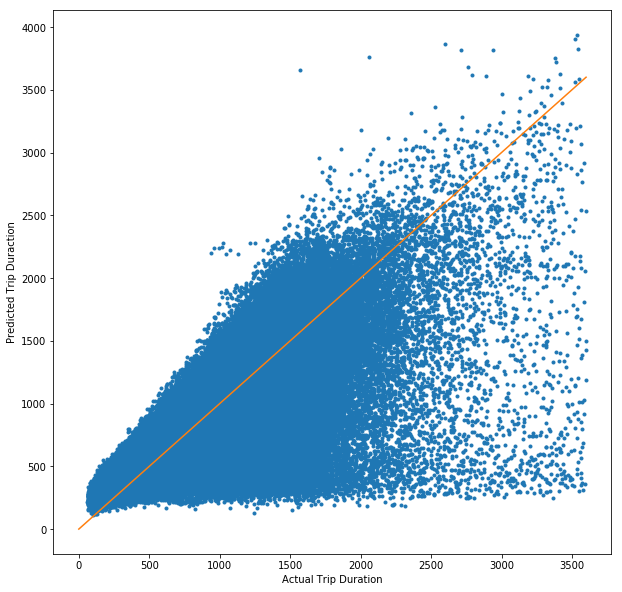

In [44]:
# plot prediction and actual data
y_pred = model.predict(X_test) 
plt.figure(figsize=(10, 10))
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duraction')
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 3600, 4000)
y = x
plt.plot(x, y)
plt.show()

In [45]:
model.coef_

array([ 2.01559262e-01,  1.82800989e+00,  2.06755493e-03, -8.06925397e-01,
        8.63757649e-02,  4.44838315e-04,  3.35732050e-03,  2.80555941e-03,
       -2.14719937e-04, -5.01427868e+14, -2.63340610e+01, -1.80986772e+00,
       -6.95594253e+01,  5.17835340e+00, -1.14233163e+14, -1.14233163e+14,
       -1.14233163e+14, -1.14233163e+14, -1.14233163e+14, -1.14233163e+14,
       -1.14233163e+14,  7.30449668e+13,  7.30449668e+13,  7.30449668e+13,
        7.30449668e+13,  7.30449668e+13,  7.30449668e+13,  7.30449668e+13,
        7.30449668e+13,  7.30449668e+13,  7.30449668e+13,  7.30449668e+13,
        7.30449668e+13, -3.33862192e+15, -3.33862192e+15, -3.33862192e+15,
        3.47867404e+14, -1.59517337e+14,  4.82715280e+15,  2.20728927e+14,
       -7.11238251e+13,  2.06028987e+14,  2.86424030e+14,  2.86424030e+14,
        2.86424030e+14,  2.00457204e+14, -2.01874743e+14, -1.40431368e+14,
       -4.68116014e+15, -1.40431368e+14, -7.47362654e+13,  3.60996499e+14,
        4.46963325e+14, -

## Improvements:
Use the Google Maps API (https://developers.google.com/maps/documentation/distance-matrix/intro) to extract routes from the origin and destination, improving upon the straight-line distance. But hey, while we're at it, the API also outputs estimated trip duration which is exactly what we're looking for! Unfortuately, Google recently cut off free access to the API. It now costs $0.005 per query.

## The Mayor has a couple of hypothesis which he needs you to verify with the given data. “Do you find a correlation between the star rating and length of reviews?”

In [ ]:
review.head()

In [46]:
corr_df = pd.DataFrame()

In [47]:
corr_df['stars'] = review['stars']

In [48]:
corr_df['review_length'] = review['text'].str.len()

In [49]:
corr_df = corr_df.dropna()

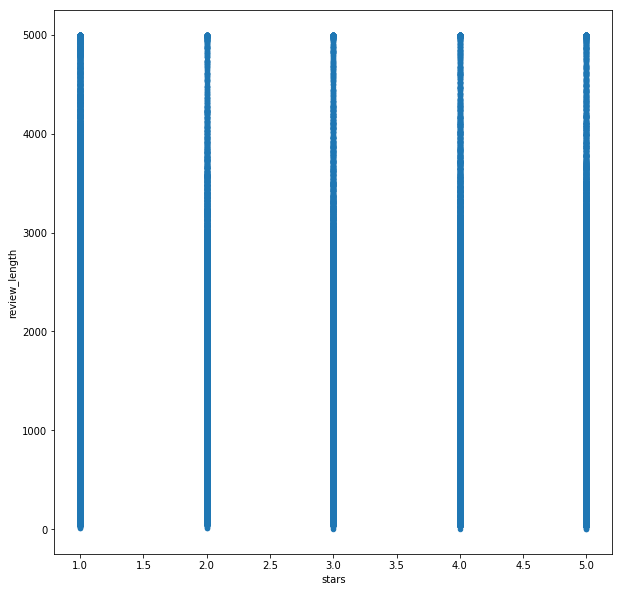

In [50]:
corr_df.plot(x='stars', y='review_length', kind='scatter', style='o', figsize=(10, 10))
plt.show()

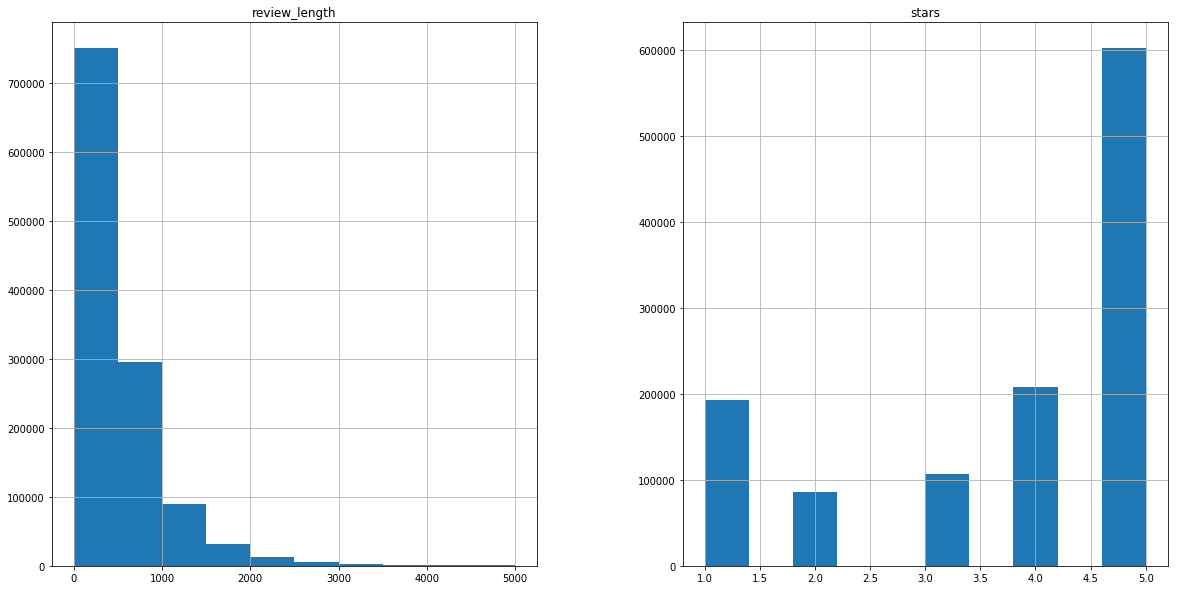

In [51]:
corr_df.hist(figsize=(20, 10))
plt.show()

In [52]:
from scipy.stats import linregress
linregress(corr_df['stars'], corr_df['review_length'])

LinregressResult(slope=-74.60250345114228, intercept=819.8866119452658, rvalue=-0.22207838254262444, pvalue=0.0, stderr=0.2997187072487137)

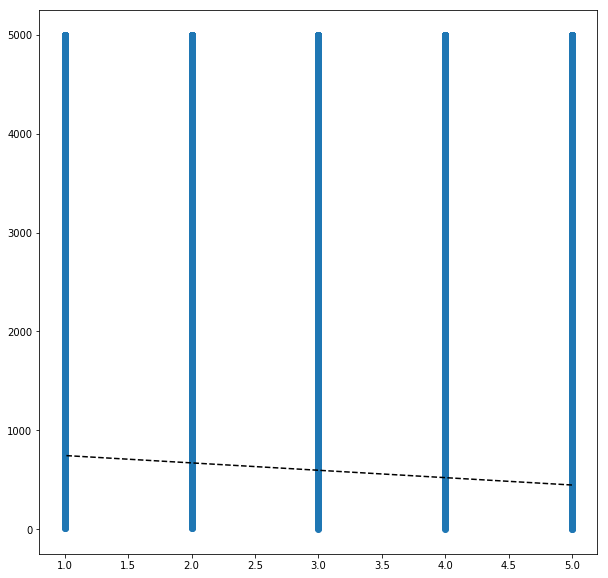

In [53]:
fit = np.polyfit(corr_df['stars'], corr_df['review_length'],1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(corr_df['stars'], corr_df['review_length'], 'o', corr_df['stars'], fit_fn(corr_df['stars']), '--k')
plt.show()

## The Mayor also wants us to identify the topics from the reviews of restaurants and explore if these topics are insightful and whether they can be used as inputs to some other classification or predictive work in the future. To do this learn a set of topics by applying topic modeling algorithms such as LDA on textual reviews. Choose the number of topics in a data-driven fashion such as by using a figure that plots perplexity versus number of topics. 

In [3]:
restaurant_ids = yelp[(yelp['categories'].str.contains('Restaurants') &
                      (yelp['is_open'] == 1))
                     ]['business_id'].tolist()

In [4]:
restaurant_reviews = review[review['business_id'].isin(restaurant_ids)]['text']

In [5]:
doc_complete = restaurant_reviews.tolist()

In [6]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]

In [7]:
len(doc_clean)

670315

In [8]:
# Take a sample of 50,000 reviews in order to speed up processing time
doc_clean_sample = np.random.choice(doc_clean, 50000, replace=False).tolist()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(doc_clean_sample, test_size=0.2, random_state=42)

In [11]:
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(train)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in train]

In [12]:
num_topics = [5, 10, 15, 20, 30, 40, 50, 75]

In [13]:
perplexity = []
models = {}

for num in num_topics:
    print(num)
    Lda = gensim.models.ldamodel.LdaModel
    lda_model = Lda(doc_term_matrix,
                    id2word = dictionary,
                    num_topics=num,
                    passes=10,
                    chunksize=100,
                    update_every=1)
    models[str(num)] = lda_model
    perplexity.append(lda_model.log_perplexity([dictionary.doc2bow(doc) for doc in test]))

5
10
15
20
30
40
50
75


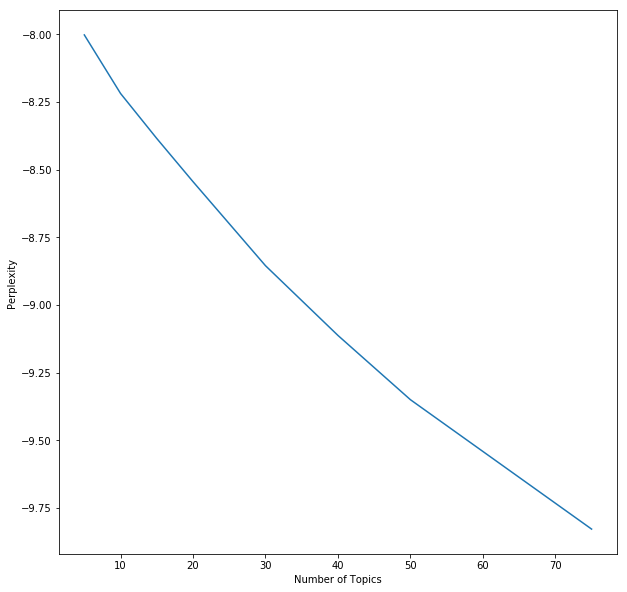

In [19]:
plt.figure(figsize=(10, 10))
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.plot(num_topics, perplexity)
plt.show()

In [57]:
best = 50
models[str(best)].print_topics(num_topics=best, num_words=20)

[(0,
  '0.070*"okay" + 0.059*"warm" + 0.055*"thank" + 0.050*"vegetarian" + 0.046*"medium" + 0.036*"cute" + 0.036*"finish" + 0.031*"outstanding" + 0.030*"wall" + 0.028*"classic" + 0.025*"cozy" + 0.025*"opinion" + 0.017*"welcome" + 0.017*"new" + 0.017*"you" + 0.016*"york" + 0.015*"didnt" + 0.015*"flat" + 0.014*"piping" + 0.012*"based"'),
 (1,
  '0.097*"quality" + 0.081*"meat" + 0.070*"fast" + 0.051*"though" + 0.048*"clean" + 0.047*"price" + 0.026*"charge" + 0.022*"better" + 0.019*"tried" + 0.019*"even" + 0.016*"bomb" + 0.016*"hot" + 0.016*"favourite" + 0.015*"personal" + 0.014*"raw" + 0.013*"twice" + 0.013*"way" + 0.013*"overpriced" + 0.013*"ridiculous" + 0.010*"running"'),
 (2,
  '0.087*"soup" + 0.058*"fish" + 0.044*"noodle" + 0.031*"2" + 0.027*"crispy" + 0.025*"choice" + 0.024*"dish" + 0.022*"flavour" + 0.022*"3" + 0.022*"4" + 0.021*"shrimp" + 0.020*"special" + 0.020*"nothing" + 0.018*"level" + 0.017*"cold" + 0.017*"morning" + 0.017*"disappointing" + 0.016*"taste" + 0.015*"rating" + 0.